In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
# Load data
df = pd.read_excel("/content/Online Retail.xlsx")
df = df.drop(['Description', 'InvoiceNo'], axis=1)

# Encode country
df['Country_Encoded'] = df['Country'].astype('category').cat.codes

# Extract date features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

# Drop irrelevant columns
df = df.drop(['InvoiceDate', 'Country', 'StockCode', 'CustomerID'], axis=1)

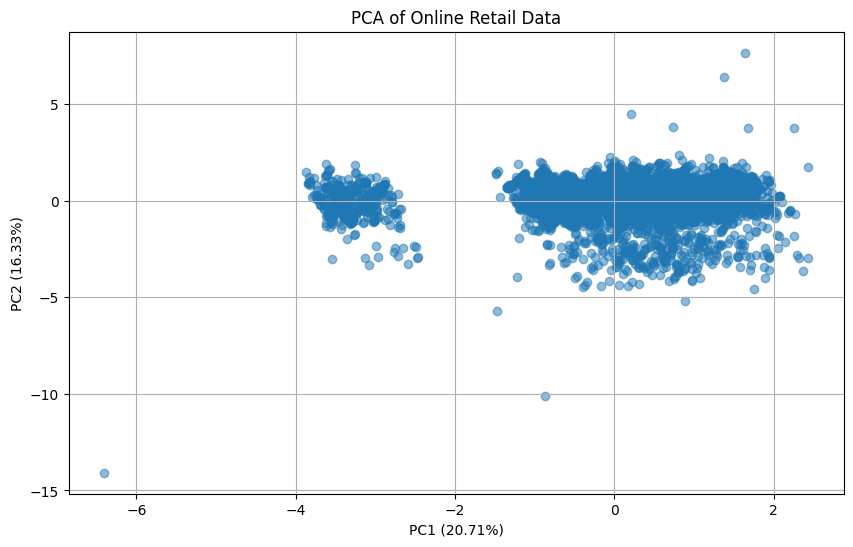

In [4]:
# Sampling
np.random.seed(42)
sample_df = df.sample(n=5000, random_state=42)

# Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_df)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of Online Retail Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True)
plt.show()

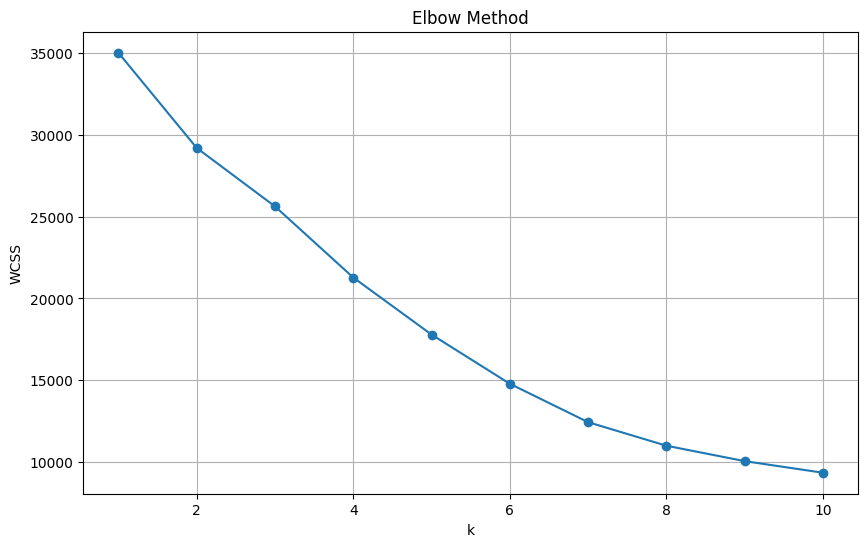

In [5]:
# Elbow Method
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

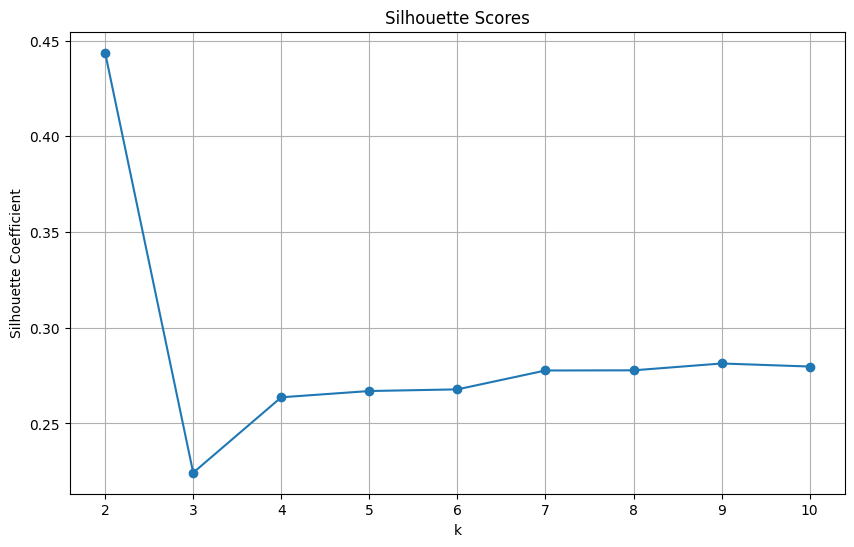

In [6]:
# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
plt.show()

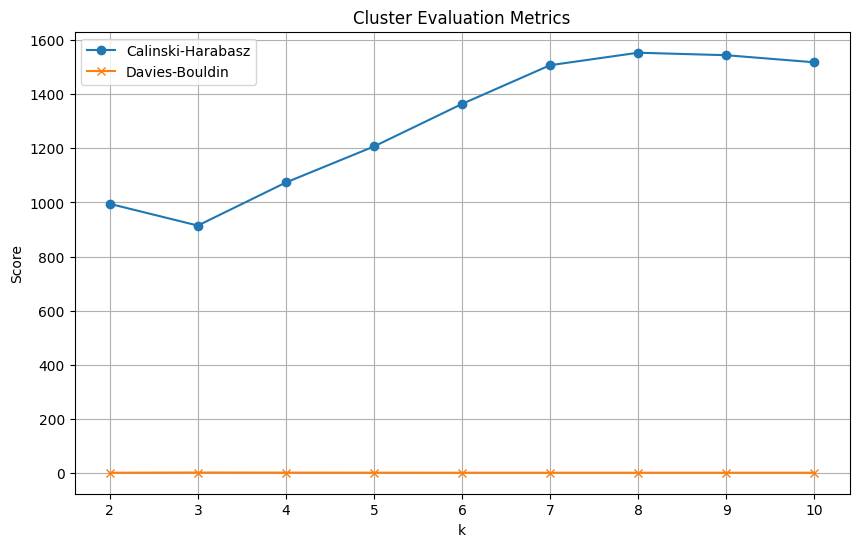

In [7]:
# Calinski-Harabasz and Davies-Bouldin Index
ch_scores, db_scores = [], []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    ch_scores.append(calinski_harabasz_score(scaled_data, labels))
    db_scores.append(davies_bouldin_score(scaled_data, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), ch_scores, label='Calinski-Harabasz', marker='o')
plt.plot(range(2, 11), db_scores, label='Davies-Bouldin', marker='x')
plt.title('Cluster Evaluation Metrics')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

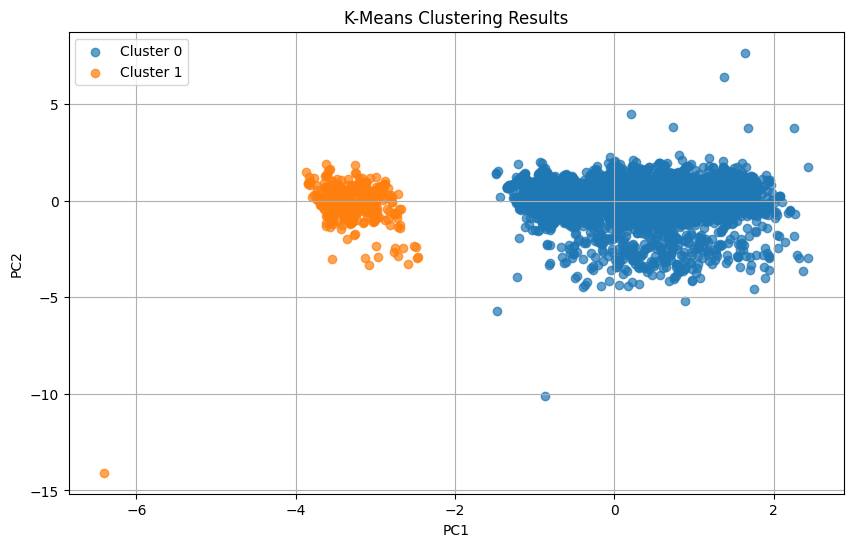

In [8]:
# Best k based on Silhouette Score
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]

# K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_data)

# PCA Scatter with K-Means
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    plt.scatter(pca_result[kmeans_labels == i, 0],
                pca_result[kmeans_labels == i, 1],
                label=f'Cluster {i}', alpha=0.7)
plt.title('K-Means Clustering Results')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

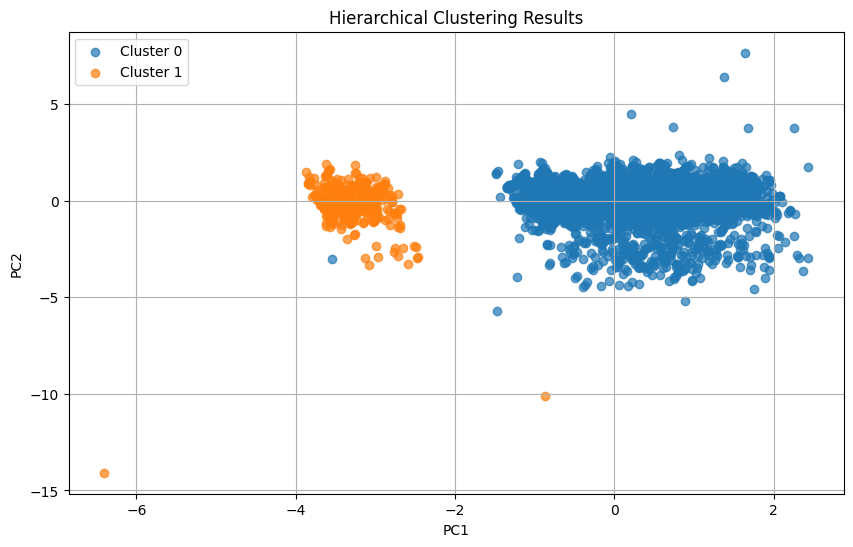

In [9]:
# Hierarchical Clustering
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = agg.fit_predict(scaled_data)

# PCA Scatter with Hierarchical
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    plt.scatter(pca_result[hierarchical_labels == i, 0],
                pca_result[hierarchical_labels == i, 1],
                label=f'Cluster {i}', alpha=0.7)
plt.title('Hierarchical Clustering Results')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

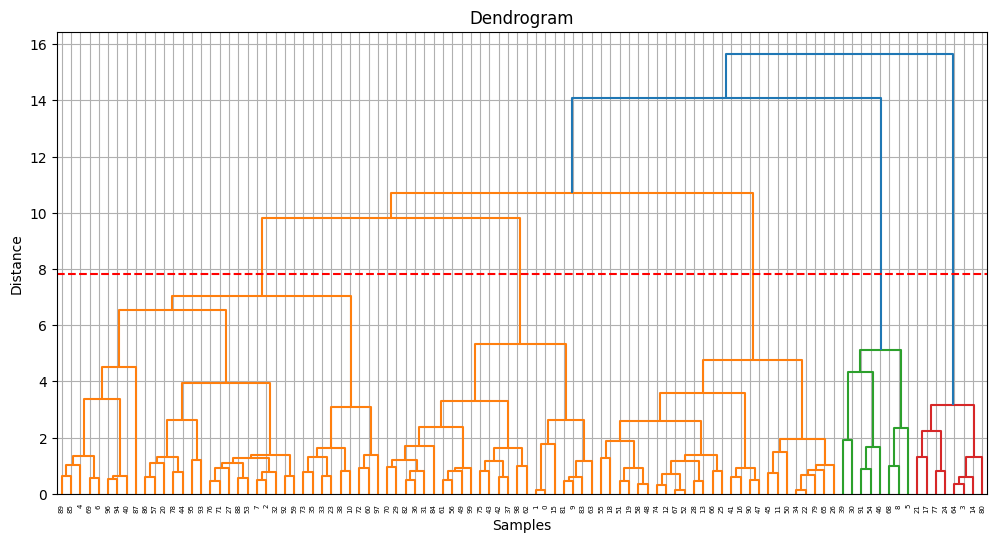

In [10]:
# Dendrogram (sampled)
sample_indices = np.random.choice(range(len(scaled_data)), size=100, replace=False)
linkage_matrix = linkage(scaled_data[sample_indices], method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.axhline(y=np.max(linkage_matrix[:, 2])/2, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [11]:
# Comparison Table
comparison_df = pd.crosstab(pd.Series(kmeans_labels, name='KMeans'),
                            pd.Series(hierarchical_labels, name='Hierarchical'))
print("\nClustering Comparison Table:")
print(comparison_df)  # Compare how clusters overlap


Clustering Comparison Table:
Hierarchical     0    1
KMeans                 
0             4606    1
1                1  392


# Penjelasan Matematika untuk Evaluasi Clustering

## 1. Within-Cluster Sum of Squares (WCSS) - Elbow Method

Rumus:
$$
WCSS = \\sum_{i=1}^{k} \\sum_{x \\in C_i} \\|x - \\mu_i\\|^2
$$

Keterangan:
- $k$: jumlah cluster
- $x$: data point
- $\\mu_i$: centroid dari cluster $C_i$

Semakin kecil WCSS, semakin kompak cluster-nya. Namun, penurunan WCSS mulai mengecil pada titik tertentu — inilah yang disebut **elbow point**.

---

## 2. Silhouette Coefficient

Rumus:
$$
s(i) = \\frac{b(i) - a(i)}{\\max(a(i), b(i))}
$$

Keterangan:
- $a(i)$: rata-rata jarak dari titik $i$ ke semua titik lain dalam cluster yang sama
- $b(i)$: rata-rata jarak dari titik $i$ ke titik-titik di cluster terdekat yang berbeda
- Nilai $s(i)$ berada di antara -1 dan 1. Nilai mendekati 1 berarti cluster bagus.

---

## 3. Calinski-Harabasz Index

Rumus:
$$
CH = \\frac{Tr(B_k)}{k - 1} \\bigg/ \\frac{Tr(W_k)}{n - k}
$$

Keterangan:
- $Tr(B_k)$: trace dari matriks antar-cluster (antara centroid dan rata-rata global)
- $Tr(W_k)$: trace dari matriks intra-cluster (variasi internal dalam cluster)
- $n$: total data point
- $k$: jumlah cluster

Semakin tinggi nilai CH, semakin baik pemisahan antar cluster.

---

## 4. Davies-Bouldin Index

Rumus:
$$
DB = \\frac{1}{k} \\sum_{i=1}^{k} \\max_{j \\ne i} \\left( \\frac{s_i + s_j}{d_{ij}} \\right)
$$

Keterangan:
- $s_i$: rata-rata jarak antara anggota cluster $i$ dan centroid-nya
- $d_{ij}$: jarak antara centroid cluster $i$ dan $j$
- Semakin rendah nilai DB, semakin baik kualitas cluster.


